## [Introduction to Pyro](http://pyro.ai/examples/intro_long.html#Introduction-to-Pyro)

In [ ]:
%reset -s -f

In [48]:
import logging
import os

In [49]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
import pyro

In [51]:
assert pyro.__version__.startswith('1.8')

In [52]:
pyro.enable_validation(True)
pyro.set_rng_seed(234)

In [53]:
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [54]:
%matplotlib inline
plt.style.use(style='ggplot')

___

Most data analysis problems can be understood as elaborations on three basic high-level questions:

- What do we know about the problem before observing any data?

- What conclusions can we draw from data given our prior knowledge?

- Do these conclusions make sense?

In the probabilistic or Bayesian approach to data science and machine learning, we formalize these in terms of mathematical operations on probability distributions.

$$p_{\theta}({\bf z} | {\bf x}) = \frac{p_{\theta}({\bf x} , {\bf z})}{
\int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z}) }$$

Marginal Likelihood or Evidence$$p_{\theta}({\bf x}) = \int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z})$$

$$\theta_{\rm{max}} = \rm{argmax}_\theta p_{\theta}({\bf x}) = \rm{argmax}_\theta \int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z})$$

___

In [55]:
data_url = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"

In [56]:
data = pd.read_csv(data_url, encoding='ISO-8859-1')

In [57]:
data.columns

Index(['isocode', 'isonum', 'country', 'rugged', 'rugged_popw', 'rugged_slope',
       'rugged_lsd', 'rugged_pc', 'land_area', 'lat', 'lon', 'soil', 'desert',
       'tropical', 'dist_coast', 'near_coast', 'gemstones', 'rgdppc_2000',
       'rgdppc_1950_m', 'rgdppc_1975_m', 'rgdppc_2000_m', 'rgdppc_1950_2000_m',
       'q_rule_law', 'cont_africa', 'cont_asia', 'cont_europe', 'cont_oceania',
       'cont_north_america', 'cont_south_america', 'legor_gbr', 'legor_fra',
       'legor_soc', 'legor_deu', 'legor_sca', 'colony_esp', 'colony_gbr',
       'colony_fra', 'colony_prt', 'colony_oeu', 'africa_region_n',
       'africa_region_s', 'africa_region_w', 'africa_region_e',
       'africa_region_c', 'slave_exports', 'dist_slavemkt_atlantic',
       'dist_slavemkt_indian', 'dist_slavemkt_saharan', 'dist_slavemkt_redsea',
       'pop_1400', 'european_descent'],
      dtype='object')

In [58]:
df = data[['cont_africa', 'rugged', 'rgdppc_2000']]

In [59]:
df = df[np.isfinite(df.rgdppc_2000)]

In [60]:
df['log_rgdppc_2000'] = np.log(df.rgdppc_2000)

In [69]:
df.columns

Index(['cont_africa', 'rugged', 'rgdppc_2000', 'log_rgdppc_2000'], dtype='object')

In [61]:
train = torch.tensor(df.values, dtype=torch.float)

In [62]:
train.shape

torch.Size([170, 4])

In [70]:
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 3]

In [71]:
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

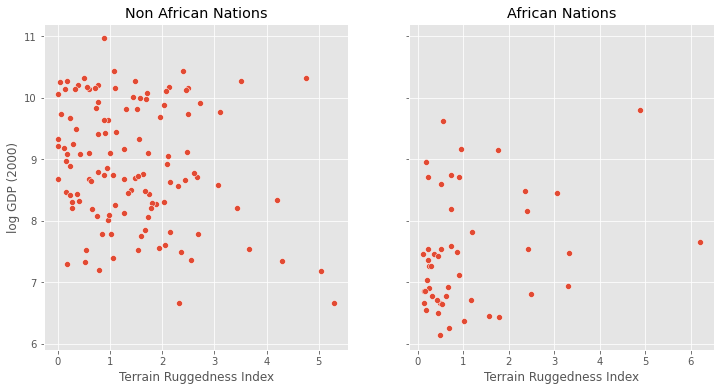

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["log_rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")

sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["log_rgdppc_2000"],
                ax=ax[1])

ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

Probabilistic models in Pyro are specified as Python functions model(*args, **kwargs) that generate observed data from latent variables using special primitive functions whose behavior can be changed by Pyro’s internals depending on the high-level computation being performed.

Specifically, the different mathematical pieces of model() are encoded via the mapping:

1. latent random variables $z \Longleftrightarrow$  pyro.sample

2. observed random variables $y \Longleftrightarrow$  pyro.sample with the obs keyword argument

3. learnable parameters $\theta \Longleftrightarrow$  pyro.param

4. plates $\Longleftrightarrow$ pyro.plate context managers

In [73]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

### Bayesian Model

In [76]:
def reg_model(is_cont_africa, ruggedness, log_gdp=None):
    alpha = pyro.sample('alpha', dist.Normal(0., 10))
    beta_A = pyro.sample("beta_a", dist.Normal(0., 1))
    beta_R = pyro.sample("beta_r", dist.Normal(0., 1))
    beta_AR = pyro.sample("beta_ar", dist.Normal(0., 1))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10))

    mu = alpha + beta_A * is_cont_africa + beta_R * ruggedness + beta_AR * is_cont_africa * ruggedness

    with pyro.plate("observations", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mu, sigma), obs=log_gdp)

In [75]:
pyro.render_model(
                    reg_model, 
                    model_args=(is_cont_africa, ruggedness, log_gdp), 
                    render_distributions=True, 
                    render_params=True
                    )

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [77]:
%%time

pyro.clear_param_store()

auto_guide = pyro.infer.autoguide.AutoNormal(reg_model)
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()

svi = pyro.infer.SVI(reg_model, auto_guide, adam, elbo)

losses = []

for step in range(1000):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 ==0:
        logging.info("Elbo loss is {}".format(loss))

Elbo loss is 735.3918184041977
Elbo loss is 536.296494603157
Elbo loss is 475.3832063674927
Elbo loss is 389.6755142211914
Elbo loss is 316.91041803359985
Elbo loss is 258.52192705869675
Elbo loss is 247.38642448186874
Elbo loss is 250.32260483503342
Elbo loss is 249.2216039299965
Elbo loss is 247.85185986757278


CPU times: user 6.57 s, sys: 84 µs, total: 6.57 s
Wall time: 6.57 s


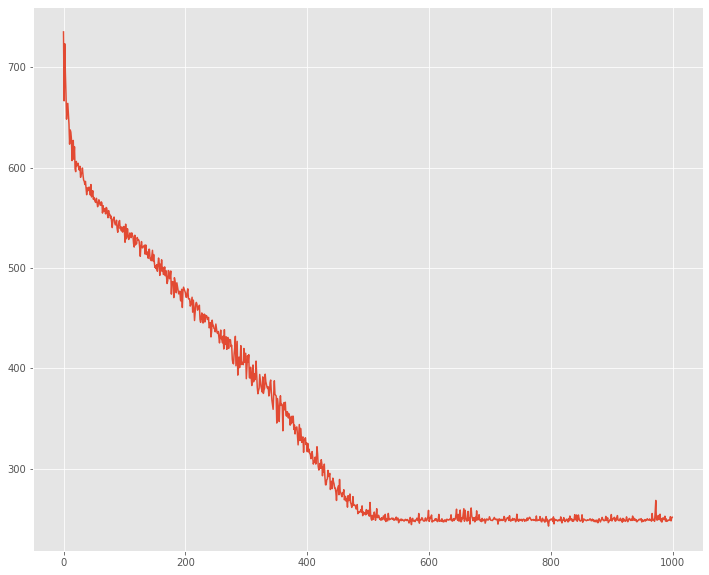

In [78]:
plt.figure(figsize=(12,10))
plt.plot(losses)

In [79]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha 9.18729
AutoNormal.scales.alpha 0.06538503
AutoNormal.locs.beta_a -1.8743266
AutoNormal.scales.beta_a 0.11928638
AutoNormal.locs.beta_r -0.16122633
AutoNormal.scales.beta_r 0.035741687
AutoNormal.locs.beta_ar 0.29324397
AutoNormal.scales.beta_ar 0.0770535
AutoNormal.locs.sigma -2.2788274
AutoNormal.scales.sigma 0.06405103


In [80]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

In [81]:
gamma_within_africa = samples['beta_r'] + samples['beta_ar']
gamma_outside_africa = samples['beta_r']

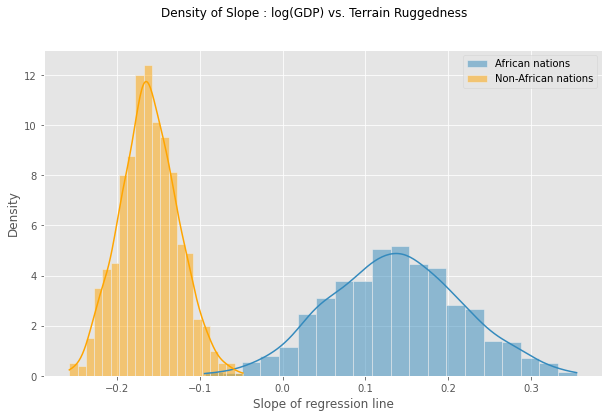

In [82]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

### Bayesian Model Evaluation with Posterior Predictive Checks

In [85]:
preds = pyro.infer.Predictive(reg_model, guide=auto_guide, num_samples=800)
svi_samples = preds(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples['obs']

In [86]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})

In [87]:
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

[Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 1.0, 'African Nations')]

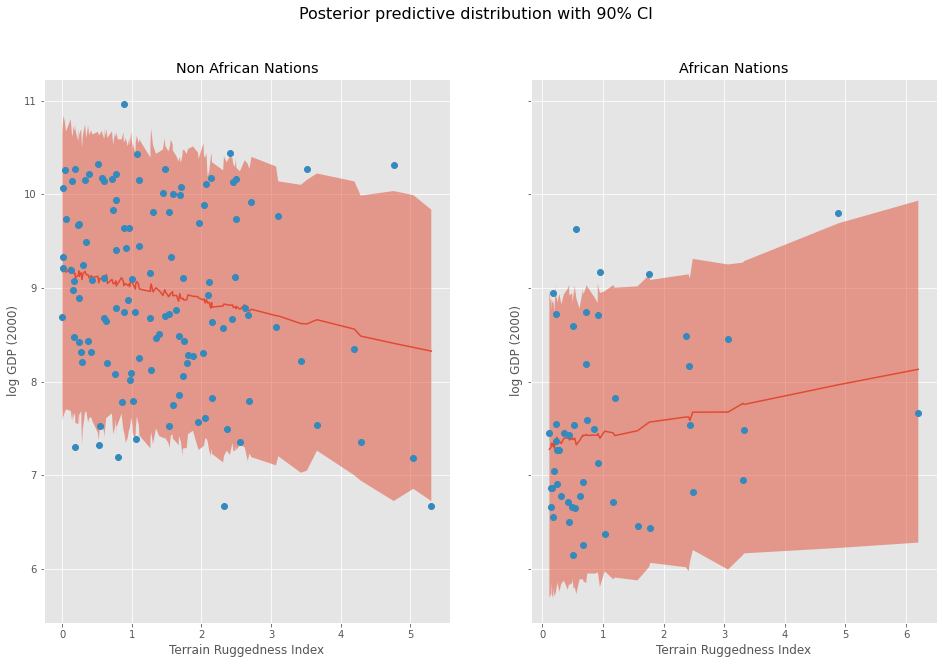

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(
                    non_african_nations["rugged"], 
                    non_african_nations["y_perc_5"], 
                    non_african_nations["y_perc_95"], 
                    alpha=0.5
                )
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations")
